In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

D:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pd_data = pd.read_csv('0613_flt_IM.csv', nrows=5000)

In [3]:
pd_data.columns = ['Time', 'Idrms', 'Iqrms', 'Ws', 'Tmpu', 'Vdrms', 'Vqrms', 'ph', 'qh', 'Wr', 'Te']

In [4]:
pd_data

,Time,Idrms,Iqrms,Ws,Tmpu,Vdrms,Vqrms,ph,qh,Wr,Te
0,0.0000,0.261342,-0.102466,376.991478,-0.769213,0.467916,-0.017616,0.125634,0.038633,0.959587,-0.769371
1,0.0001,0.261337,-0.102464,376.991476,-0.769213,0.467912,-0.017619,0.125631,0.038632,0.959588,-0.769355
2,0.0002,0.261332,-0.102463,376.991473,-0.769213,0.467909,-0.017622,0.125628,0.038630,0.959588,-0.769338
3,0.0003,0.261326,-0.102462,376.991467,-0.769213,0.467905,-0.017626,0.125624,0.038629,0.959588,-0.769320
4,0.0004,0.261320,-0.102462,376.991460,-0.769214,0.467902,-0.017629,0.125621,0.038628,0.959588,-0.769302
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.4995,0.237324,-0.156949,378.234141,-0.769483,0.456126,-0.115410,0.127943,0.039395,0.959700,-0.782943
4996,0.4996,0.237319,-0.156960,378.231538,-0.769506,0.456111,-0.115454,0.127945,0.039387,0.959709,-0.782950
4997,0.4997,0.237313,-0.156971,378.228936,-0.769529,0.456095,-0.115498,0.127946,0.039380,0.959718,-0.782956
4998,0.4998,0.237307,-0.156982,378.226334,-0.769552,0.456080,-0.115541,0.127948,0.039373,0.959727,-0.782961


# 这里先验证ph 和 qh 是不是由VI的dq 的 rms值计算得到

count    5.000000e+03
mean    -1.243503e-03
std      3.233325e-03
min     -2.807017e-02
25%     -1.844987e-04
50%      2.914294e-07
75%      8.288539e-06
max      4.759962e-03
dtype: float64

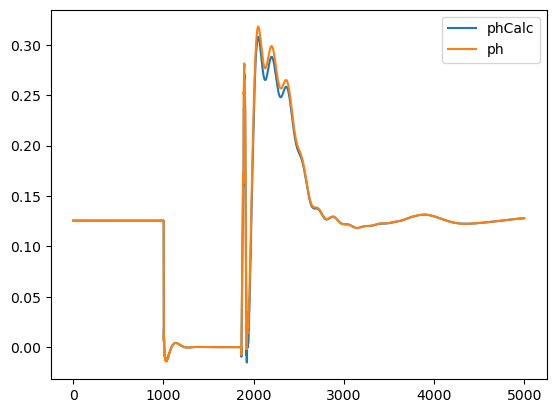

In [5]:
def v1(row):
    return (row.Vdrms * row.Idrms + row.Vqrms * row.Iqrms)*1.0

pd_data['phCalc'] = pd_data.apply(v1, axis=1) * 1.0125
pd_data[['phCalc','ph']].plot()
(pd_data['phCalc'] - pd_data['ph']).describe()

<Axes: >

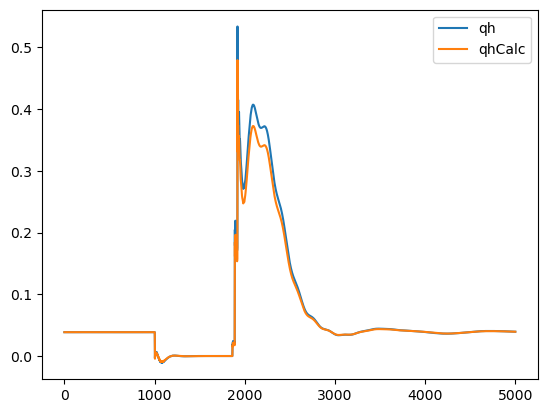

In [6]:
def v2(row):
    return (row.Vqrms * row.Idrms - row.Vdrms * row.Iqrms)*1.0


pd_data['qhCalc'] = pd_data.apply(v2, axis=1) * 0.8915
pd_data[['qh','qhCalc']].plot()

In [7]:
# 定义参数
rs = 2.0110e-2
xs = 1.0448e-1
xmu = 9.0424
rr = 4.5768e-2
xr = 1.0448e-1
Omega_b = 377
Hm = 0.075352957

x0 = xs + xmu
xp = xs + xr * xmu / (xr + xmu)
T0p = (xr + xmu) / (Omega_b * rr)

In [8]:
pd_data['edp'] = pd_data['Vdrms'] - (rs * pd_data['Idrms'] - xp * pd_data['Iqrms'])
pd_data['eqp'] = pd_data['Vqrms'] - (rs * pd_data['Iqrms'] + xp * pd_data['Idrms'])

# 验证电磁转矩的公式Te = edp * id + eqp * iq, 表格里的Te数据是标幺值，基准值为0.159, 所有计算均为rms值，如果是peak值则有名值是需要乘以0.106的

count    5000.000000
mean        0.009598
std         0.055451
min        -0.070436
25%        -0.000237
50%         0.000001
75%         0.000478
max         0.501316
dtype: float64

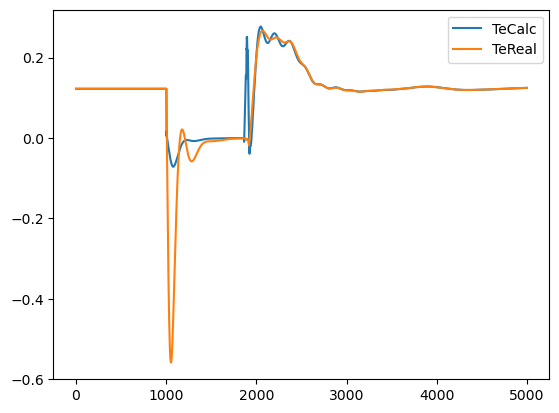

In [9]:
pd_data['TeCalc'] = (pd_data['edp'] * pd_data['Idrms'] + pd_data['eqp'] * pd_data['Iqrms']) # 0.1061为基准值，这里计算的有名值，csv文件里面获取的Te是pu值
pd_data['TeReal'] = - pd_data['Te'] * 0.15924
pd_data[['TeCalc','TeReal']].plot()
(pd_data['TeCalc']-pd_data['TeReal']).describe()

# 验证Tm和Te的公式在Hm=0.7...的情况下是否正确,此处都是标幺值计算，Te和Tmpu都已经转换为了标幺值，Wr是转子侧转速（pu）, Ws的基准值是377 rad/s

In [10]:
# 计算滑差 σ
pd_data['sigma'] = 1 - pd_data['Wr']

# 计算滑差的导数 σ_dot
sigma_dt = (pd_data['sigma'][2:].to_numpy() - pd_data['sigma'][:-2].to_numpy()) / (pd_data['Time'][2] - pd_data['Time'][0])
pd_data['sigma_dot'] = [sigma_dt[0]] + list(sigma_dt) + [sigma_dt[-1]]

# 计算公式
pd_data['sigma_Calc'] = (pd_data['Te'] - pd_data['Tmpu']) / (2 * Hm)

count    5000.000000
mean       -0.000009
std         0.038400
min        -0.161387
25%        -0.000296
50%        -0.000033
75%         0.000317
max         0.606064
dtype: float64

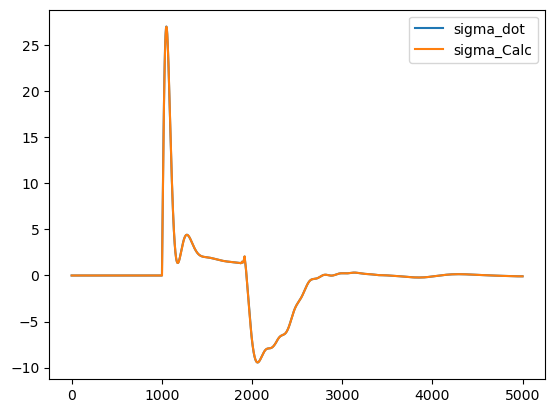

In [11]:
pd_data[['sigma_dot','sigma_Calc']].plot()
(pd_data['sigma_dot']-pd_data['sigma_Calc']).describe()

# 接下来验证edp和eqp的微分方程部分，书中公式15.62
## 前面的验证证明了id iq vd vq Te 和 Tm的量测数据均没有问题， 计算出来的edp和eqp都和数据对应得上，因此不存在edp和eqp的计算错误问题 （0612更新：这里其实不好说，edp和eqp在计算Te的时候基本没涉及微分部分）
## 参数方面rs xs xmu xr均没有问题，还剩rr没有验证

In [12]:
# # 计算数据求出的导数 (numerical derivatives)
edp_dt = (pd_data['edp'][2:].to_numpy() - pd_data['edp'][:-2].to_numpy()) / (pd_data['Time'][2] - pd_data['Time'][0])
eqp_dt = (pd_data['eqp'][2:].to_numpy() - pd_data['eqp'][:-2].to_numpy()) / (pd_data['Time'][2] - pd_data['Time'][0])

pd_data['edp_dot_data'] = [edp_dt[0]] + list(edp_dt) + [edp_dt[-1]]
pd_data['eqp_dot_data'] = [eqp_dt[0]] + list(eqp_dt) + [eqp_dt[-1]]

count    5000.000000
mean       -2.595446
std        30.581370
min     -1006.909739
25%        -2.206180
50%        -1.330738
75%        -0.701850
max       360.986058
dtype: float64

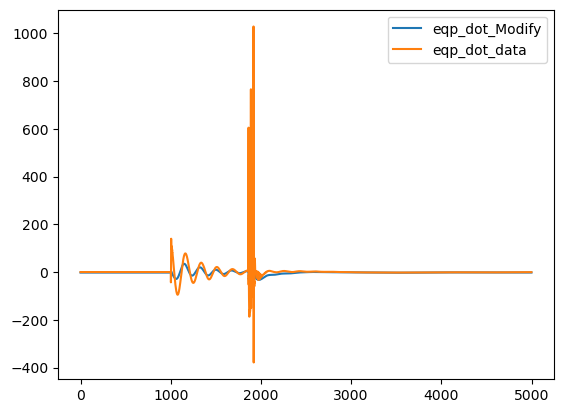

In [13]:
Omega_b = 377
pd_data['edp_dot_Calc'] = Omega_b * pd_data['sigma'] * pd_data['eqp'] - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data['eqp_dot_Calc'] = -Omega_b * pd_data['sigma'] * pd_data['edp'] - (pd_data['eqp'] - (x0 - xp) * pd_data['Idrms']) / T0p
pd_data['eqp_dot_Modify'] = pd_data['eqp_dot_Calc'] 
pd_data[['eqp_dot_Modify', 'eqp_dot_data']].plot()
(pd_data['eqp_dot_Modify']-pd_data['eqp_dot_data']).describe()

count    5000.000000
mean        0.558665
std        57.542459
min     -1238.336761
25%        -0.190799
50%         0.083850
75%         0.605207
max      2257.502889
dtype: float64

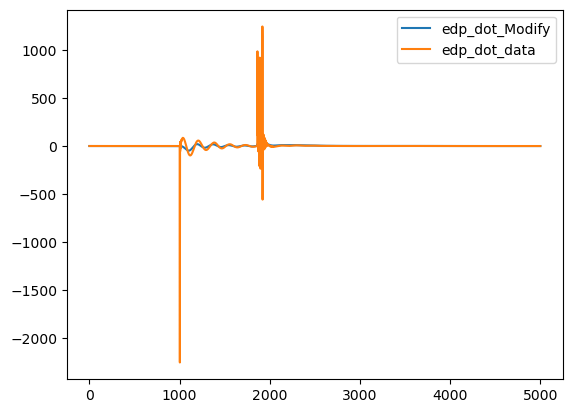

In [20]:
pd_data['edp_dot_Modify'] = pd_data['edp_dot_Calc']
pd_data[['edp_dot_Modify', 'edp_dot_data']].plot()
(pd_data['edp_dot_Modify']-pd_data['edp_dot_data']).describe()

In [15]:
pd_data['edp_dot_Calc1'] = Omega_b * pd_data['sigma'] * pd_data['eqp'] - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data['edp_dot_Calc2'] =  - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data['edp_dot_Calc3'] = Omega_b * pd_data['sigma'] * pd_data['eqp']

In [16]:
T0p_Verify = - 1 / ((pd_data['edp_dot_data'] - Omega_b * pd_data['sigma'] * pd_data['eqp']) / (pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']))

In [17]:
T0p_Verify.describe()

count    5000.000000
mean        0.582487
std         6.700940
min       -93.883480
25%         0.297410
50%         0.442370
75%         0.607408
max       351.556539
dtype: float64

In [18]:
T0p

0.5301145159742343